In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 8)

from scipy import stats
from scipy.interpolate import griddata, RectBivariateSpline #\
#     interp2d, griddata, RegularGridInterpolator, RectBivariateSpline, \
#     NearestNDInterpolator, LinearNDInterpolator

# Add path to vivarium_research_lsff/nanosim_models to sys.path so imports will work from parent folder
import sys, os.path
# Note: Assuming pwd = vivarium_research_lsff/nanosim_models/notebooks
sys.path.append(os.path.abspath(".."))

import lbwsg # in `vivarium_research_lsff/nanosim_models`
import lbwsg_plots # in `vivarium_research_lsff/nanosim_models`

!date
!whoami
!pwd

/ihme/homes/ndbs/vivarium_research_lsff/nanosim_models/notebooks
Fri Jun 25 17:24:48 PDT 2021
ndbs


In [2]:
%load_ext autoreload
%autoreload 2

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Step 0: Get LBWSG category data and save to `.csv`

In [3]:
cat_df = lbwsg.get_category_data()
cat_df

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga,ga_width,ga_midpoint,bw,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,cat116,20227,"Birth prevalence - [38, 40) wks, [1000, 1500) g",38,40,1000,1500,"[38, 40)",2,39.0,"[1000, 1500)",500,1250.0
55,cat117,20228,"Birth prevalence - [38, 40) wks, [1500, 2000) g",38,40,1500,2000,"[38, 40)",2,39.0,"[1500, 2000)",500,1750.0
56,cat123,20232,"Birth prevalence - [40, 42) wks, [1500, 2000) g",40,42,1500,2000,"[40, 42)",2,41.0,"[1500, 2000)",500,1750.0
57,cat124,20224,"Birth prevalence - [37, 38) wks, [1000, 1500) g",37,38,1000,1500,"[37, 38)",1,37.5,"[1000, 1500)",500,1250.0


### Rename `'ga'` and `'bw'` columns

I'm intending to do this eventually in the underlying code, but it will require making the change in multiple places.

In [4]:
cat_df.rename(columns={'ga':'ga_interval','bw':'bw_interval'}, inplace=True)

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save file and read back in to test format

In [5]:
cat_df_filename = 'lbwsg_category_data.csv'
cat_df.to_csv(cat_df_filename, index=False)
pd.read_csv(cat_df_filename)

,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga_interval,ga_width,ga_midpoint,bw_interval,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,cat116,20227,"Birth prevalence - [38, 40) wks, [1000, 1500) g",38,40,1000,1500,"[38, 40)",2,39.0,"[1000, 1500)",500,1250.0
55,cat117,20228,"Birth prevalence - [38, 40) wks, [1500, 2000) g",38,40,1500,2000,"[38, 40)",2,39.0,"[1500, 2000)",500,1750.0
56,cat123,20232,"Birth prevalence - [40, 42) wks, [1500, 2000) g",40,42,1500,2000,"[40, 42)",2,41.0,"[1500, 2000)",500,1750.0
57,cat124,20224,"Birth prevalence - [37, 38) wks, [1000, 1500) g",37,38,1000,1500,"[37, 38)",1,37.5,"[1000, 1500)",500,1250.0


# Step 1: Get coordinates of LBWSG category midpoints indexed by category

In [6]:
interval_data_by_cat = cat_df.set_index('lbwsg_category')
ga_midpoints = interval_data_by_cat['ga_midpoint']
bw_midpoints = interval_data_by_cat['bw_midpoint']

print(ga_midpoints)
# print(f'{ga_midpoints.shape=}\n')
print()
print(bw_midpoints)
# print(f'{bw_midpoints.shape=}')

lbwsg_category
cat2      12.0
cat8      12.0
cat10     25.0
cat11     27.0
          ... 
cat116    39.0
cat117    39.0
cat123    41.0
cat124    37.5
Name: ga_midpoint, Length: 58, dtype: float64

lbwsg_category
cat2       250.0
cat8       750.0
cat10      750.0
cat11      750.0
           ...  
cat116    1250.0
cat117    1750.0
cat123    1750.0
cat124    1250.0
Name: bw_midpoint, Length: 58, dtype: float64


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 2: Get LBWSG relative risks by category and take logs

In [7]:
draw=999
sex='Female'
age_group_id=2

lbwsg_hdf = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data/lbwsg_data.hdf'
rr = pd.read_hdf(lbwsg_hdf, '/gbd_2019/relative_risk/diarrheal_diseases')
some_rrs = lbwsg.get_relative_risk_set_by_category(rr, draw=draw, sex=sex, age_group_id=age_group_id)
logrr = np.log(some_rrs)
logrr.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


lbwsg_category
cat2     6.849704
cat8     6.645169
cat10    6.204308
cat11    5.488672
cat14    4.881388
Name: relative_risk, dtype: float64

### Make sure that the category indices are lined up for GA, BW, and log(RR)

In [8]:
assert ga_midpoints.index.equals(logrr.index) and bw_midpoints.index.equals(logrr.index)

# Step 3: Define intermediate grid $G$ for nearest neighbor interpolation

Here we define the x-coordinates and y-coordinates of the grid. The actual grid will be constructd implicitly via broadcasting during the interpolation step.

In [9]:
ga_min = interval_data_by_cat['ga_start'].min()
ga_max = interval_data_by_cat['ga_end'].max()
bw_min = interval_data_by_cat['bw_start'].min()
bw_max = interval_data_by_cat['bw_end'].max()

print("GA: min, max =", (ga_min, ga_max), ", BW: min, max =", (bw_min, bw_max))

# Intermediate grid: Category midpoints plus boundary points
ga_grid = np.append(np.unique(ga_midpoints), [ga_min, ga_max]); ga_grid.sort()
bw_grid = np.append(np.unique(bw_midpoints), [bw_min, bw_max]); bw_grid.sort()
print(ga_grid, f"{ga_grid.shape=}")
print(bw_grid, f"{bw_grid.shape=}")

GA: min, max = (0, 42) , BW: min, max = (0, 4500)
[ 0.  12.  25.  27.  29.  31.  33.  35.  36.5 37.5 39.  41.  42. ] ga_grid.shape=(13,)
[   0.  250.  750. 1250. 1750. 2250. 2750. 3250. 3750. 4250. 4500.] bw_grid.shape=(11,)


## Step 3.5: Define a dense grid on the rectangle for plotting interpolated values

Again, we only need the x and y coordinates, and the actual plotting grid `gai` $\times$ `bwi` will be constructed automatically upon interpolation.

In [10]:
# Dense grid for plotting interpolated values:
# - Fill out the whole GAxBW rectangle
# - Use different number of grid points in each direction to easily verify correct orientations
gai = np.linspace(ga_min, ga_max, 200) # gai = "GA interpolation points"
bwi = np.linspace(bw_min, bw_max, 150) # bwi = "BW interpolation points"
print(f"{gai.shape=}, {bwi.shape=}")
print(f"Broadcast shape for GA x BW plotting grid = {(gai[:,None]+bwi[None,:]).shape}")

gai.shape=(200,), bwi.shape=(150,)
broadcast shape for GA x BW plotting grid = (200, 150)


# Step 4: Extrapolate to $G$ via nearest neighbor interpolation


From [SciPy's `griddata` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html):


> `scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)`<br>
> Interpolate unstructured D-D data.
>
> **Parameters**
>
> `points` : *2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).*<br>
> Data point coordinates.
>
> `values` : *ndarray of float or complex, shape (n,)*<br>
> Data values.
>
> `xi` : *2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.*<br>
> Points at which to interpolate data.
>
> ...

In our case, the dimension is D=2, and we have n=58 data points, one for each LBWSG category. We will use the second calling convention for the datapoints `points` and the interpolation points `xi`:

- `points` : The length 2 tuple of 1D-arrays `(ga_midpoints, bw_midpoints)`, each with shape `(58,)`
- `values` : The 1D-array `logrr` of shape `(58,)`
- `xi` : The length 2 tuple `(ga_grid[:,None], bw_grid[None,:])` of 2D-arrays with shapes `(13, 1)` and `(1,11)`, broadcastable to the shape `(13,11)` of the intermediate grid $G$

We will use `method=nearest` to get nearest neighbor interpolation, with `rescale=True` since GA and BW have incomparable and drastrically different scales. The parameter `fill_value` has no effect for `method=nearest`.

In [22]:
# Check shapes of GA grid and BW grid to make sure broadcasting will work
print(f"{ga_grid[:,None].shape=}")
print(f"{bw_grid[None,:].shape=}")
print("Broadcast shape for GA x BW intermediate grid G =", (ga_grid[:,None] + bw_grid[None,:]).shape)

ga_grid[:,None].shape=(13, 1)
bw_grid[None,:].shape=(1, 11)
Broadcast shape for GA x BW intermediate grid G = (13, 11)


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Nearest neighbor extrapolation to grid G using griddata
%time logrr_grid_nearest = griddata( \
    (ga_midpoints, bw_midpoints), logrr, (ga_grid[:,None], bw_grid[None,:]), \
    method='nearest', rescale=True)

print(f"Shape of intermediate grid G: {logrr_grid_nearest.shape=}")
print("min log(RR) on G =", logrr.min(), ", max log(RR) on G =", logrr.max())

CPU times: user 1.09 ms, sys: 30 µs, total: 1.12 ms
Wall time: 979 µs
Shape of intermediate grid G: logrr_grid_nearest.shape=(13, 11)
min log(RR) on G = 0.0 , max log(RR) on G = 6.849704447162709


## Step 4.5: Plot nearest neighbor interpolation on the whole rectangle $[0,42\text{wk}]\times [0,4500\text{g}]$

### This plot shows what RR values were assigned to each grid point in $G$ compared to the RR values at the category midpoints.

First we need to interpolate to the dense plotting grid `gai` $\times$ `bwi` via nearest neighbor.

In [13]:
# Interpolate to dense grid using nearest neighbor to visualize our interpolation to G
# logrri_nearest = "log(RR) interpolated via nearest neighbor"
%time logrri_nearest = griddata( \
    (ga_midpoints, bw_midpoints), logrr, (gai[:,None], bwi[None,:]),\
    method='nearest', rescale=True)
print(logrri_nearest.shape)

CPU times: user 19.7 ms, sys: 752 µs, total: 20.4 ms
Wall time: 19.3 ms
(200, 150)


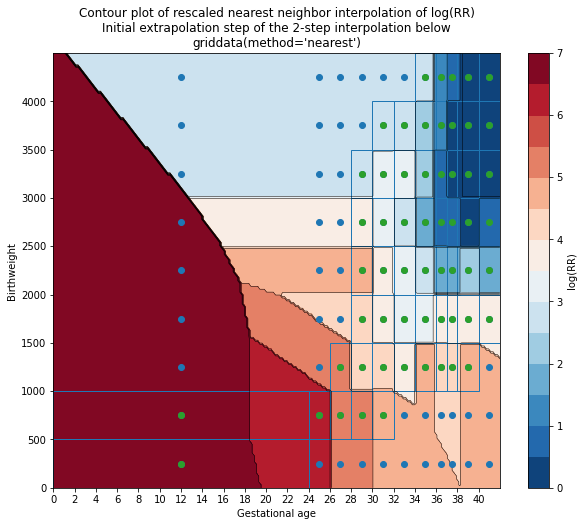

In [14]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_nearest, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='rescaled nearest neighbor',
    subtitle='Initial extrapolation step of the 2-step interpolation below'
    "\ngriddata(method='nearest')",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

# Step 5: Interpolate to $[0,42\text{wk}]\times [0,4500\text{g}]$ via bilinear interpolation

## Step 5a: Create a `RectBivariateSpline` object from the extrapolated values on $G$

In [15]:
%time rbvspline = RectBivariateSpline(ga_grid, bw_grid, logrr_grid_nearest, kx=1, ky=1)

CPU times: user 596 µs, sys: 0 ns, total: 596 µs
Wall time: 524 µs


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Step 5b: Interpolate to the dense grid `gai` $\times$ `bwi` so we can plot the bilinear interpolation on the whole rectangle

In [16]:
# Interpolate values of log(RR) on the dense GAxBW grid
%time logrri_bilinear = rbvspline(gai, bwi)
print(f"Shape of plotting grid: {logrri_bilinear.shape=}, {logrri_bilinear.size=}")
print(f"{logrri_bilinear.min()=}, {logrri_bilinear.max()=}")

CPU times: user 270 µs, sys: 97 µs, total: 367 µs
Wall time: 279 µs
Shape of plotting grid: logrri_bilinear.shape=(200, 150), logrri_bilinear.size=30000
logrri_bilinear.min()=0.0, logrri_bilinear.max()=6.84970444716271


## Step 5.5: Plot interpolated values of $\log(\mathit{RR})$ on the whole rectangle

Note that the contour line for $\log(\mathit{RR})=0$ goes through the midpoints of `cat53` and `cat54` rather than tracing the category boundaries.

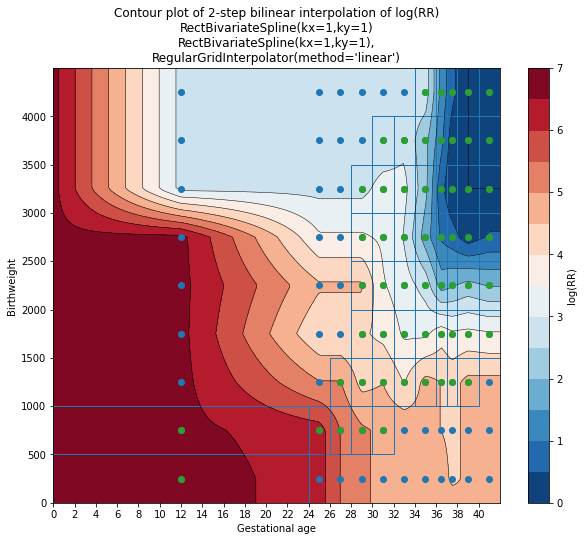

In [17]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, logrri_bilinear, cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bilinear',
    subtitle="RectBivariateSpline(kx=1,ky=1)"
    "\nRectBivariateSpline(kx=1,ky=1),"
    "\nRegularGridInterpolator(method='linear')",
    draw_category_rectangles=True, draw_all_gridpoints=True
);

# Step 6: Exponentiate to recover the relative risks

In [18]:
# rri = "RR interpolated values"
rri = np.exp(logrri_bilinear)
print(f"{rri.shape=}")
print(f"{rri.min()=}, {rri.max()=}")

rri.shape=(200, 150)
rri.min()=1.0, rri.max()=943.601981212184


/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 7: Reset TMREL categories to 1

### First we need to look up whether each interpolated point $(\text{GA}_i, \text{BW}_i)$ is in a TMREL category.

In [19]:
TMREL_CATEGORIES = ('cat53', 'cat54', 'cat55', 'cat56')

# Set index of cat_df to a MultiIndex of pandas IntervalIndex objects
# to enable looking up LBWSG categories by (GA,BW) coordinates
cat_data_by_interval = cat_df.set_index(['ga_interval', 'bw_interval'])

# Create a MultiIndex of (GA,BW) coordinates to look up
gai_bwi_coordinates = pd.MultiIndex.from_product((gai,bwi), names=('gai_coordinate','bwi_coordinate'))

# Create a DataFrame to store category data for each (GA,BW) coordinate
gai_bwi_cat_data = pd.DataFrame(index=gai_bwi_coordinates)

# Look up category for each (GA,BW) coordinate and check whether it's a TMREL category
gai_bwi_cat_data['lbwsg_category'] = cat_data_by_interval['lbwsg_category'].reindex(gai_bwi_coordinates)
gai_bwi_cat_data['in_tmrel'] = gai_bwi_cat_data['lbwsg_category'].isin(TMREL_CATEGORIES)
gai_bwi_cat_data

lbwsg_category  in_tmrel
gai_coordinate bwi_coordinate                         
0.0            0.000000                 cat2     False
               30.201342                cat2     False
               60.402685                cat2     False
               90.604027                cat2     False
...                                      ...       ...
42.0           4409.395973               NaN     False
               4439.597315               NaN     False
               4469.798658               NaN     False
               4500.000000               NaN     False

[30000 rows x 2 columns]

### Now we can create a mask to reset RR values in the TMREL categories to 1.0.

In [23]:
print("Number of interpolation points in TMREL =", gai_bwi_cat_data['in_tmrel'].sum())

# Make a 2D mask the same shape as the dense grid, and note that some TMREL RRs are > 1
tmrel_mask = gai_bwi_cat_data['in_tmrel'].to_numpy().reshape(rri.shape)
print(f"\n{tmrel_mask.shape=}")
print(f"{rri[tmrel_mask].shape=}, {rri[tmrel_mask].min()=}, {rri[tmrel_mask].max()=}")

# Use the mask to set all TMREL RRs to 1, and check that it worked
rri_clipped = np.where(tmrel_mask, 1, rri)
print(f"\n{rri_clipped.shape=}")
print(f"{rri_clipped[tmrel_mask].shape=}, {rri_clipped[tmrel_mask].min()=}, {rri_clipped[tmrel_mask].max()=}")

Number of interpolation points in TMREL = 594

tmrel_mask.shape=(200, 150)
rri[tmrel_mask].shape=(594,), rri[tmrel_mask].min()=1.0, rri[tmrel_mask].max()=1.4123935796274139

rri_clipped.shape=(200, 150)
rri_clipped[tmrel_mask].shape=(594,), rri_clipped[tmrel_mask].min()=1.0, rri_clipped[tmrel_mask].max()=1.0


## Step 7.5: Plot $\log(\mathit{RR})$ after TMREL values are clipped to 1

We can see that the contour line for $\log(\mathit{RR})=0$ has shifted from the midpoints of `cat53` and `cat54` to the category boundaries.

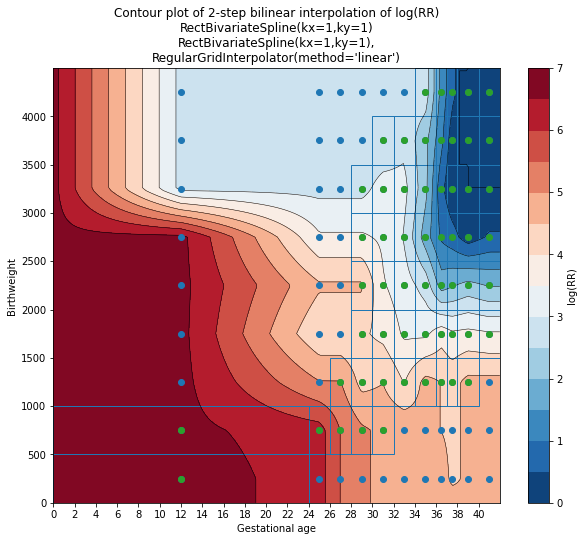

In [21]:
lbwsg_plots.plot_log_rrs(
    gai, bwi, np.log(rri_clipped), cat_df,
    logrri_xy_matches_axes=False,
    interpolation_type='2-step bilinear',
    subtitle="RectBivariateSpline(kx=1,ky=1)"
    "\nRectBivariateSpline(kx=1,ky=1),"
    "\nRegularGridInterpolator(method='linear')",
    draw_category_rectangles=True, draw_all_gridpoints=True
);